In [3]:
# Import EDA libraries
import os
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='ticks')
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Ford GoBike Bike Ride Forecasting

## Table of Contents
* [4. Summary Statistics](#4.-Summary-Statistics)
* [5. Time Series Decomposition](#5.-Time-Series-Decomposition)
* [6. Stationarity](#6.-Stationarity)
* [7. Correlation](#7.-Correlation)
	* [7.1 Correlation Matrix](#7.1-Correlation-Matrix)
	* [7.2 Autocorrelation](#7.2-Autocorrelation)
* [8. Conclusions](#8.-Conclusions)



In [4]:
%store -r start_time_daily
%store -r start_time_hourly
%store -r log_start_time_hourly
%store -r fb

## 4. Summary Statistics

In [5]:
fb.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,member_age
count,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,453159.000000,453159.000000
mean,1099.009521,95.034245,37.771653,-122.363927,92.184041,37.771844,-122.363236,1672.533079,1980.404787,37.595213
std,3444.146451,86.083078,0.086305,0.105573,84.969491,0.086224,0.105122,971.356959,10.513488,10.513488
min,61.000000,3.000000,37.317298,-122.444293,3.000000,37.317298,-122.444293,10.000000,1886.000000,19.000000
25%,382.000000,24.000000,37.773492,-122.411726,23.000000,37.774520,-122.410345,787.000000,1974.000000,30.000000
50%,596.000000,67.000000,37.783521,-122.398870,66.000000,37.783830,-122.398525,1728.500000,1983.000000,35.000000
75%,938.000000,139.000000,37.795392,-122.391034,134.000000,37.795392,-122.391034,2520.000000,1988.000000,44.000000
max,86369.000000,340.000000,37.880222,-121.874119,340.000000,37.880222,-121.874119,3733.000000,1999.000000,132.000000


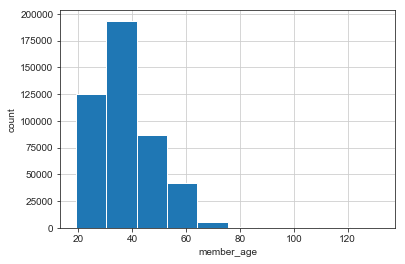

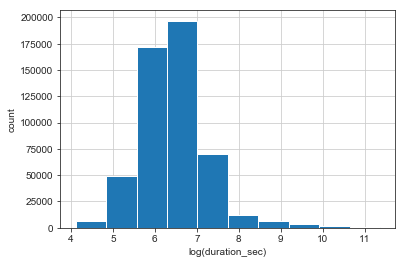

In [39]:
# plot member_age histogram
fb.member_age.hist()
plt.xlabel('member_age')
plt.ylabel('count')
plt.show()
# plot duration histogram
duration_sec = np.log(fb.duration_sec)
duration_sec.hist()
plt.xlabel('log(duration_sec)')
plt.ylabel('count')

plt.show()

## 5. Time Series Decomposition

- **Level**: The baseline value for the series if it were a straight line.
- **Trend**: The optional and often linear increasing or decreasing behavior of the series over time.
- **Seasonality**: The optional repeating patterns or cycles of behavior over time.
- **Noise**: The optional variability in the observations that cannot be explained by the model.

Daily Time Series Decomposition:

The trend is monotonically upward with a seasonality of 1 week. 

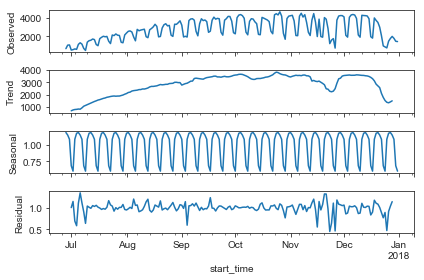

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(start_time_daily, model='multiplicative')
result.plot()
plt.show()

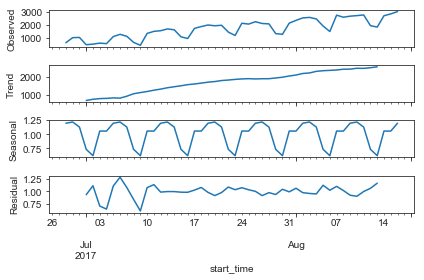

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(start_time_daily.iloc[0:50], model='multiplicative')
result.plot()
plt.show()

Hourly Time Series Decomposition:

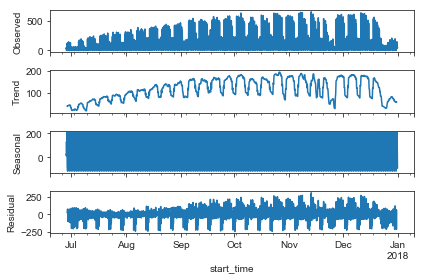

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(start_time_hourly, model='additive')
result.plot()
plt.show()

A closer look at the hourly dataset shows that mornings and early evenings are popular times to ride bikes. Seasonality of 1-day is also observed, which may be used for differencing.

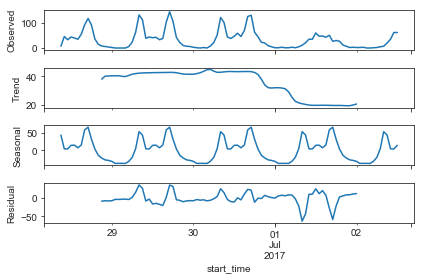

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(start_time_hourly.iloc[0:100], model='additive')
result.plot()
plt.show()

## 6. Stationarity

The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. To determine stationarity, three methods were used:

- **Line Plots**: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
- **Summary Statistics**: review the summary statistics for your data for seasons or random partitions and check for obvious or signicant differences.
- **Statistical Tests**: use statistical tests to check if the expectations of stationarity are met or have been violated.

It was observed that the daily data is not stationary. 

ADF Statistic: -2.293395
p-value: 0.174107
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


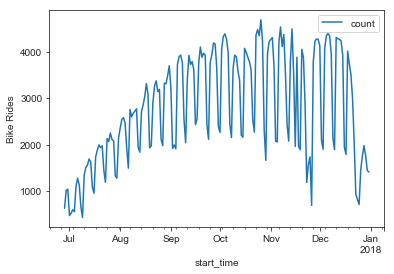

In [33]:
# calculate the stationarity of the daily time series without differencing
result = adfuller(start_time_daily.values.flatten())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot
start_time_daily.plot()
plt.ylabel('Bike Rides')
plt.show()

In [43]:
def mean_var_split(list):
    split = int(round(len(list)/2,0))
    split1, split2 = list[0:split], list[split:]
    mean1, mean2 = split1.mean(), split2.mean()
    var1, var2 = split1.var(), split2.var()
    print('split 2 mean = %f, split 2 mean = %f'%(mean1, mean2))
    print('split 2 variance = %f, split 2 variance = %f'%(var1, var2))


A second assessment based on the mean and variance further supports that the raw data is a non-stationary process. The mean should be closer to 0, and the variance should be roughly similar in magnitude.

In [44]:
mean_var_split(start_time_daily)

split 2 mean = 2406.627660, split 2 mean = 3155.666667
split 2 variance = 1080242.343743, split 2 variance = 1324913.376812


The data was differenced by two days. The Augmented Dickey-Fuller test is used, which is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

It was shown that the test statistic is -2.811, which is more extreme than the critical value at ~5%, therefore we reject the null hypothesis. The time series is stationary and does not have a time-dependent structure.

ADF Statistic: -2.811794
p-value: 0.056609
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


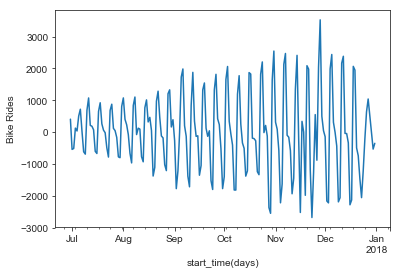

In [110]:
# create and summarize stationary version of time series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
X = start_time_daily.values.flatten()
X = X.astype('float32')
# difference data by days
day_interval = 2
daily_stationary = difference(X, day_interval)
daily_stationary.index = start_time_daily.index[day_interval:]
# check if stationary
result = adfuller(daily_stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
daily_stationary.to_csv('daily_stationary.csv')
# plot
daily_stationary.plot()
plt.ylabel('Bike Rides')
plt.xlabel('start_time(days)')
plt.show()

The mean is now closer to zero, although the variance is over two times higher for split 2. However, to avoid overdifferencing, a 2-day lag was kept. 

In [111]:
mean_var_split(daily_stationary)

split 2 mean = 67.152174, split 2 mean = -53.494624
split 2 variance = 759596.306259, split 2 variance = 2333416.730949


The log(hourly data) already demonstrates statistically significant stationarity, but further differencing would be beneficial for removing seasonality.

ADF Statistic: -4.316763
p-value: 0.000415
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


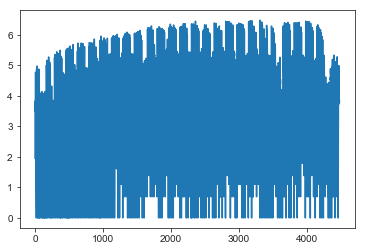

In [47]:
X = log_start_time_hourly.values.flatten()
X = X.astype('float32')
# check if stationary
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot
hourly_stationary = pd.Series(X)
hourly_stationary.plot()
plt.show()


It was observed that the mean is nearly zero and the variance is nearly constant for both splits.

In [94]:
mean_var_split(log_start_time_hourly)

split 2 mean = 3.671750, split 2 mean = 4.039986
split 2 variance = 3.024217, split 2 variance = 2.636224


Differencing by 24 hours also demonstrated significant stationarity, but it also eliminated the seasonality.

ADF Statistic: -11.742686
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


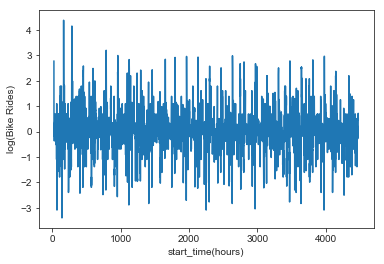

In [82]:
# create and summarize stationary version of time series

# create a differenced series
X = log_start_time_hourly.values.flatten()
X = X.astype('float32')
# difference data by hours
hour_interval = 24
hourly_stationary = difference(X, hour_interval)
hourly_stationary.index = log_start_time_hourly.index[hour_interval:]
# check if stationary

result = adfuller(hourly_stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
hourly_stationary.to_csv('stationary.csv')
# plot
hourly_stationary.plot()
plt.ylabel('log(Bike Rides)')
plt.xlabel('start_time(hours)')
plt.show()

It was observed that the mean is nearly zero and the variance is constant for both splits.

In [95]:
mean_var_split(hourly_stationary)

split 2 mean = 0.018342, split 2 mean = -0.011171
split 2 variance = 0.525721, split 2 variance = 0.547487


## 7. Correlation

### 7.1 Correlation Matrix

Not many features are correlated aside from the location-based features, e.g. latitude and longitude

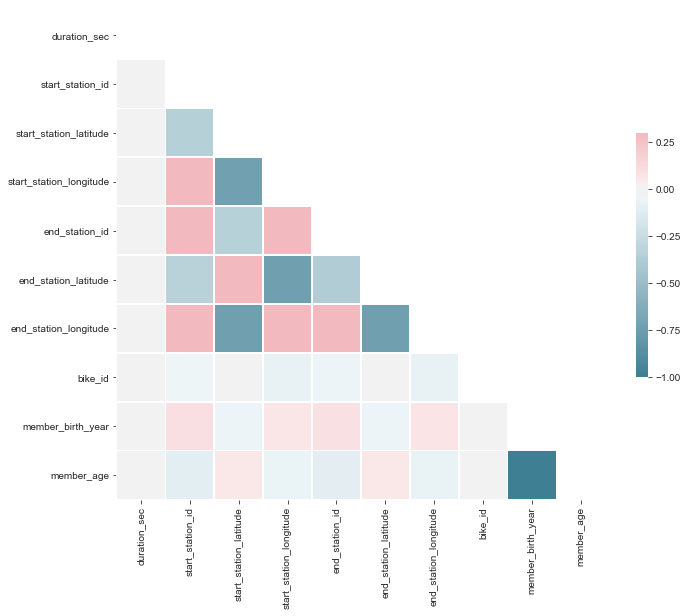

In [14]:
# Compute the correlation matrix
corr = fb.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### 7.2 Autocorrelation

More points tighter to the diagonal line suggests a stronger relationship, whereas a larger spread from the diagonal line suggests a weaker relationship.

The plots show a strong positive correlation with each value in the last week.

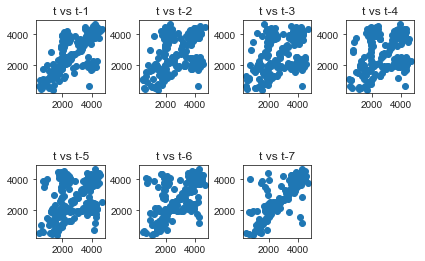

In [7]:
values = pd.DataFrame(start_time_daily.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.subplots_adjust(top=None, bottom=None, left=None, right=1, hspace=1,
                    wspace=0.5)
plt.show()

Autocorrelation function (ACF) and partial autocorrelation function (PACF)  were calculated using the differenced hourly and daily dataset. Autocorrelation is the correlation from an observation to an observation at a prior time step with intermediate time steps considered, whereas partial autocorrelation does not include intermediate time steps in the calculation. Plots were also differenced to observe the changes to the ACF and PACF plots.
- The model is AR if the ACF trails off after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for p.
- The model is MA if the PACF trails off after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for q.
- The model is a mix of AR and MA if both the ACF and PACF trail off.

The following was observed for the daily dataset:
- The ACF shows significant lags to nearly 30-day time steps.
- The PACF shows significant lags to a 60-day time step.
- The two-day differenced ACF shows significant lags to nearly 50-day time steps.
- The two-day differenced PACF shows significant lags to a 60-day time step.


Daily data autocorrelation

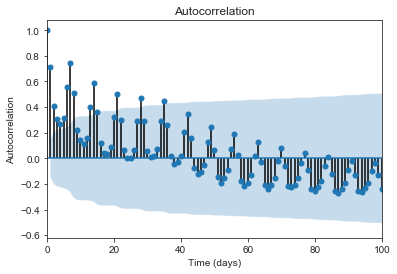

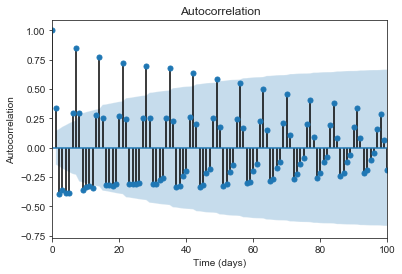

/Users/tsed/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


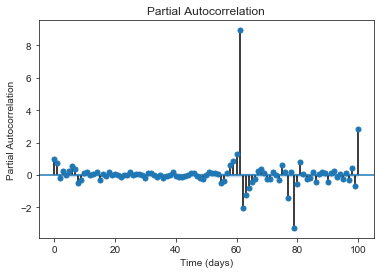

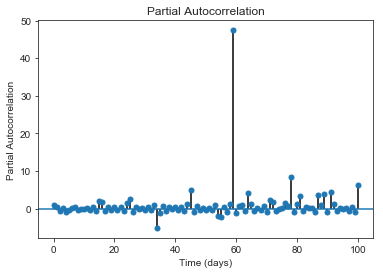

In [63]:
# ACF and PACF plots of time series
plot_acf(start_time_daily, ax=plt.gca())
plt.xlim(0,100)
plt.xlabel('Time (days)')
plt.ylabel('Autocorrelation')
plt.show()

plot_acf(daily_stationary, ax=plt.gca())
plt.xlim(0,100)
plt.xlabel('Time (days)')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(start_time_daily, ax=plt.gca(),lags=100)
plt.xlabel('Time (days)')
plt.ylabel('Partial Autocorrelation')
plt.show()

plot_pacf(daily_stationary, ax=plt.gca(),lags=100)
plt.xlabel('Time (days)')
plt.ylabel('Partial Autocorrelation')
plt.show()

Hourly data autocorrelation

A seasonal component of 24-hours was observed based on the plots below and multiples of 24-hour seasonality are viable as well, e.g. 48-hour, 72-hour, etc.

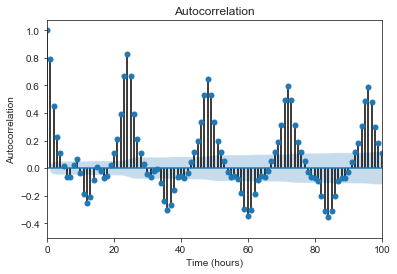

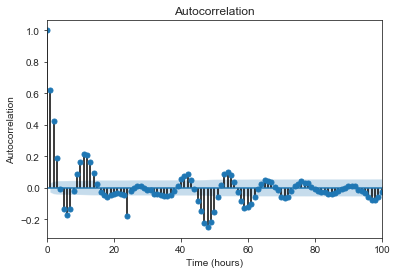

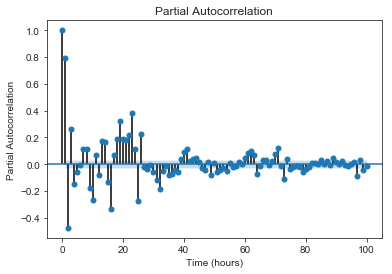

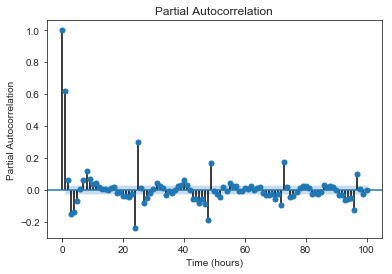

In [71]:
# ACF and PACF plots of time series
plot_acf(start_time_hourly, ax=plt.gca())
plt.xlim(0,100)
plt.xlabel('Time (hours)')
plt.ylabel('Autocorrelation')
plt.show()

plot_acf(hourly_stationary, ax=plt.gca())
plt.xlim(0,100)
plt.xlabel('Time (hours)')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(start_time_hourly, ax=plt.gca(),lags=100)
plt.xlabel('Time (hours)')
plt.ylabel('Partial Autocorrelation')
plt.show()

plot_pacf(hourly_stationary, ax=plt.gca(),lags=100)
plt.xlabel('Time (hours)')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [49]:
%store daily_stationary
%store hourly_stationary

Stored 'daily_stationary' (Series)
Stored 'hourly_stationary' (Series)
